# Lab Three, Multi-modal and Multi-task

#### *Author: Sen Yang, Hao Tian, Ishna Satyarth*

# 1 Overview

In this lab, we are using multi-task architectures to aid potential drug discovery - classifying binding affinity using ChemBL. ChEMBL (https://www.ebi.ac.uk/chembl/) is a manually curated database of bioactive molecules with drug-like properties. It brings together chemical, bioactivity and genomic data to aid the translation of genomic information into effective new drugs.

The main objective of this multi-task problem is to classify which ligands bind to which targets. Each target will be a separate task working from a shared ligand representation.

### 1.1 Raw Data Description

ChEMBL contains 2-D structures, calculated properties (e.g. logP, Molecular Weight, Lipinski Parameters, etc.) and abstracted bioactivities (e.g. binding constants, pharmacology and ADMET data). The data is abstracted and curated from the primary scientific literature, and cover a significant fraction of the SAR and discovery of modern drugs.

ChEMBL is developed and managed by ChEMBL Team (https://chembl.gitbook.io/chembl-interface-documentation/about#chembl-team-members). The most recent data (CheEMBL 28: updated on 2021-01-15) from CheEMBL can be downloaded from the official website (https://chembl.gitbook.io/chembl-interface-documentation/downloads). 

The original data contains information about following fields {"Molecule","Standard Type","Standard Relation","Standard Value","Standard Units","pChEMBL Value","Comment","Compound Key","Assay","Assay Description","BAO Format","Target","Target Pref. Name","Target Organism","Target Type","Document","Source","Max Phase","#Ro5 Violations","Molecular Weight","Ligand Efficiency BEI","Ligand Efficiency LE","Ligand Efficiency LLE","Ligand Efficiency SEI","ALogP","Assay Organism","Assay Tissue ChEMBL ID","Assay Tissue Name","Assay Cell Type","Assay Subcellular Fraction","Organism Tax ID","BAO Format ID","Published Type","Published Relation","Published Value","Published Units","Canonical Smiles","Data Validity Comment","Document Journal","Document Year","SRC ID","UO Units","Potential Duplicate"}.

The data we used for multi-task models is only a subset of the database. To be specific, we use the processed version of the dataset by Niraj Verma for his assignment 3 years ago (https://smu.box.com/s/smqmwlef0yehpieicwxqdr99k7f9ru04). However, it is still necessary to do some data preprocessing before we can train our models, which will be introduced in the following section.

***Reference:*** https://chembl.gitbook.io/chembl-interface-documentation/about 

### 1.2 Data Pre-processing

In our study, we firstly read the raw data from 'data.csv' file with ISO-8859-1 unicode and then preprocess the data as follows.

**i. Data cleaning.**  


We remove rows with missing smiles, IC50, target, and then leave only 6 columns of interests:

$$\text{Columns of interests}=\bf{\text{{id, ic50_val, unit, assay, target, smiles}}}$$

**ii. Subset the total number of tasks by target counts.**  

We are trying to keep the top 100 targets corresponding to the most assays. Here, "top" means the largest number of datalines corresponding to a specific target. From these top 100 targets, we will save the ligands that have an assay result for each of the targets.

**iii. Binarize the binding affinity for each ligand by IC50.**

Rule of "binding" binarization:

$$\text{Binding} = \left\{\begin{array}{lll} 1,& if & IC50 \le 300nm\\
0,& if & IC50 \ge 10\mu m\\
\text{Delete Row}& o.w. & \end{array}\right.$$

**iv. Featurize each ligand by RDKit.**

Each ligand is converted into features by RDKit. RDKit will convert the ligand representation into a binary vector of features.

In [55]:
import pandas as pd
import numpy as np
import collections
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Dense, Dropout, Activation, Flatten, Input
from random import shuffle
from rdkit.ML.Scoring.Scoring import CalcAUC, CalcBEDROC, CalcEnrichment
from sklearn.metrics import roc_auc_score
from rdkit.Chem import MolFromSmiles, RDKFingerprint, Descriptors
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [56]:
%%time
f = open('data.csv', 'r', encoding = "ISO-8859-1")
data = f.readlines()
f.close()

curated_data = [] 

# skip first line (header)
for line in data[1:]: 
    line = line.strip().split(',')
    if len(line) < 36:
        continue
    #[line[0], line[3],  line[4], line[8], line[11], line[36])
    #[id,      ic50_val, unit,    assay,   target,   smiles]
    curated_data.append([line[0], line[3], line[4], line[8], line[11], line[36]])


# remove \x00 to each string
for i in range (len(curated_data)):
    curated_data[i] = [c.replace('\x00','') for c in curated_data[i]]
    curated_data[i] = [c.replace('"','') for c in curated_data[i]]


# remove data with missing smiles, IC50, target

clean_data = []
target_count = collections.defaultdict(int)

for line in curated_data:
    if len(line[1]) != 0 and len(line[5]) != 0 and \
        len(line[4]) != 0 and line[4][:6] == "CHEMBL" and line[2] == "nM":
        clean_data.append(line)
        target = line[4]
        target_count[target] += 1

Wall time: 11.2 s


In [57]:
# only keep the top 100 target with the most assay
target_top_100 = [k for k, v in sorted(target_count.items(), key = lambda x : x[1], reverse = True)][:100]

In [58]:
# smiles
smiles = []
# IC50 binarization
binding = []
# target name
target = []

for line in clean_data:
    # filter only target in the top 100
    if line[4] in target_top_100:
        # binarization
        # only add IC50 <= 300 nM or >= 10 uM (10,000 nM)
        if float(line[1]) <= 300:
            binding.append(1)
        elif float(line[1]) >= 10000:
            binding.append(0)
        else:
            continue
        smiles.append(line[5])
        target.append(line[4])

target_set = list(set(target) )

Store the processed data and load it for further analysis.

In [59]:
# featurize smiles

#X_total = [list(RDKFingerprint(MolFromSmiles(line))) for line in smiles]
#X_total = np.array(X_total)

#pickle.dump(X_total, open("./X_total.pkl", "wb"))

X_total = pickle.load(open("./X_total.pkl", "rb"))
print(X_total.shape)

(191486, 2048)


### 1.3 Evaluation Criteria

We will use 3 metrics to evaluate the performance of our models.

- AUC: the area value under the ROC curve.

- BEDROC: Boltzmann-Enhanced Discrimination of ROC.

- EF: Enrichment Factor

We learned about the advantage of these 3 metircs from the following paper. 

***Reference***: Srinivas, Raghuram, Pavel V. Klimovich, and Eric C. Larson. "Implicit-descriptor ligand-based virtual screening by means of collaborative filtering." Journal of cheminformatics 10.1 (2018): 1-20.

**AUC:** The first evaluation criteria is the area under the receiver operating characteristic (AUC). In this curve the true positive rate is plotted as a function of the false positive rate to rank ligands based on probability of being active.

A superior classification model would have a high true positive rate for the highest ranked ligands, which are the ones that would be assayed first (the so-called early recognition problem). The AUC does not take into account this early recognition, so it can incorrectly judge a classification model superior if it has an overall high true positive rate, even though the true positives may not occur “early” in the ranking of ligands. Such a model would result in many needless assays before becoming sufficiently accurate. Therefore, more suitable metrics are often sought after that do take into account early recognition – the two popular choices being Enrichment Factor (EF) and Boltzmann-Enhanced Discrimination of Receiver Operating Characteristic (BEDROC).

**Enrichment Factor:** Enrichment Factor is defned as the ratio
of correctly classifed active ligands within a predefned early recognition threshold compared to the total
ligands selected by the model, further normalized by the
expected random selection of the ligands.

EF gives an estimate on how many
more actives can be found within the early recognition
threshold compared to a random distribution.

**BEDROC:** the Boltzmann-enhanced discrimination of the receiver operating characteristic (BEDROC) is also used to consider early recognition. The BEDROC metric is interpreted as the probability that an active in the ordered list will be ranked before a ligand that is drawn from a random probability distribution function which is bounded between 0 and 1.

# 2 Model

### 2.1 Model Preparation

In this study, there are 100 tasks in total corresponding to 100 targets after screening. There is only 1 modality. Therefore, this is a multi-task problem. All 100 tasks are in the same domain. 

#### Stradified Training and Testing Split

We are splitting the data in the ratio of 70:30 for Training_Data : Test_Data. Based on the histogram shown below, the number of assays is varying greatly among different targets. Therefore, we choose to use stradified training and testing split, so that we draw even percentage of samples from each group of assays.

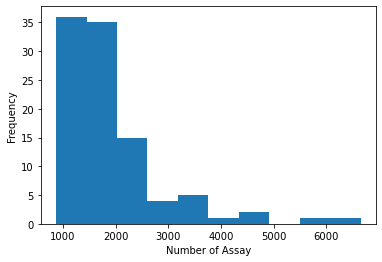

In [60]:
count = collections.Counter(target)

plt.figure()
plt.hist(count.values())
plt.xlabel("Number of Assay")
plt.ylabel("Frequency")
plt.show()

In [61]:
# split data

index = [i for i in range(len(target))]
index_train, index_test, target_train, target_test = train_test_split(index, target, stratify = target, test_size=0.3)

# init
X_train = collections.defaultdict(list)
X_test = collections.defaultdict(list)
y_train = collections.defaultdict(list)
y_test = collections.defaultdict(list)

for index, val in enumerate(index_train):
    X_train[target_train[index]].append(X_total[val])
    y_train[target_train[index]].append(binding[val])

for index, val in enumerate(index_test):
    X_test[target_test[index]].append(X_total[val])
    y_test[target_test[index]].append(binding[val])

### 2.2 Independent Target Model

**For our dataset, a general model is not possible to build.**

Because we do not have binding information (binding or not) for all pairs of ligands and targets. For a given target, we only know whether a subset of ligands are bound to it or not. For other ligands, the binding information is missing. If there is no data on whether a specific ligand is bound to a specific target, it is obviously impossible to train a general model for classification.

**Instead, we will build independent target models.**

We train each target on its own individual model. There will be 100 independent target models in total.

We are performing 10 epochs to train our model and will compare the AUC, BEDROC and EF in each epoch. The model will have 2048 input variables, 512 neurons in hidden layer 1, 256 in Hidden layer 2, 128 in hidden layer 3 to get one output unit. We are building a general sequential network using Rectifier Activation 'relu' function and Linear Activation function in the output layer. We are using 'adam' optimizer and 'Mean Squared Error' for high performance to calculate the loss.

In [62]:
# build model

# define params
INPUT_FEATURE_SIZE = 2048
# w1 unit
W1_UNIT = 512
# w2 unit
W2_UNIT = 256
# w3 unit
W3_UNIT = 128
# output unit
OUTPUT_UNIT = 1

In [63]:
# build independent model for each target
def build_independent_model():
    independent_model = keras.Sequential()
    independent_model.add(keras.Input(shape=(INPUT_FEATURE_SIZE,)))
    independent_model.add(Dense(W1_UNIT, activation="relu"))
    independent_model.add(Dense(W2_UNIT, activation="relu"))
    independent_model.add(Dense(W3_UNIT, activation="relu"))
    independent_model.add(Dense(OUTPUT_UNIT, activation="linear"))
    independent_model.compile(optimizer='adam', loss='mean_squared_error')
    return independent_model

In [64]:
%%time
EPOCHS = 10

independent_model = dict()
for target in target_set:
    independent_model[target] = build_independent_model()

# indicators
auc, ef, bedroc = [], [], []

for i in range(EPOCHS):

    for target in target_set:
        y_mtl, yhat_mtl = [], []
        
        cur = independent_model[target].fit(np.array(X_train[target]), np.array(y_train[target]).reshape(-1, 1), 
                                verbose = 0, epochs = 1, shuffle = True)
        yhat_mlp = independent_model[target].predict(np.array(X_test[target]))
        
        y_mtl.append(np.array(y_test[target]).reshape(-1, 1).ravel())
        yhat_mtl.append(yhat_mlp.ravel())
        
        # post processing
        y_mtl = np.concatenate(y_mtl).reshape(-1, 1)
        yhat_mtl = np.concatenate(yhat_mtl).reshape(-1, 1)
        scores = np.concatenate((yhat_mtl, y_mtl), axis = 1)
        scores = sorted(scores, key = lambda x : x[0], reverse = True)
        
        # calculate EF, BEDROC and AUC for each target
        ef.append(CalcEnrichment(scores, col = 1, fractions = [0.01]))
        bedroc.append(CalcBEDROC(scores, col = 1, alpha = 20))
        if len(set(y_mtl.ravel())) == 1:
            auc_temp = 0
        else:
            auc_temp = roc_auc_score(y_mtl.ravel(), yhat_mtl.ravel())
        auc.append(auc_temp)

ef = np.array(ef).reshape(EPOCHS, 100)
bedroc = np.array(bedroc).reshape(EPOCHS, 100)
auc = np.array(auc).reshape(EPOCHS, 100)

Wall time: 4min 55s


In [65]:
def post_process(ef, bedroc, auc, epochs, firstline):
    last_ef = ef[-1,:]
    last_bedroc = bedroc[-1,:]
    last_auc = auc[-1,:]

    ef_avg = np.mean(ef, axis = 1)
    bedroc_avg = np.mean(bedroc, axis = 1)
    auc_avg = np.mean(auc, axis = 1)

    # print results
    for i in range(epochs):
        if i==0:
            print(firstline)
        print("Epoch %d \tAverage AUC: %.3f;  Average EF: %.3f;  Average BEDROC: %.3f." %(i + 1, np.mean(auc_avg[i]), 
                                                              np.mean(ef_avg[i]), np.mean(bedroc_avg[i])))
    
    return last_ef, last_bedroc, last_auc, ef_avg, bedroc_avg, auc_avg

In [66]:
last_ef, last_bedroc, last_auc, ef_avg, bedroc_avg, auc_avg = post_process(ef, bedroc, auc, EPOCHS,
                                             "Independent Taget Model:\n")

Independent Taget Model:

Epoch 1 	Average AUC: 0.860;  Average EF: 2.354;  Average BEDROC: 0.912.
Epoch 2 	Average AUC: 0.894;  Average EF: 2.342;  Average BEDROC: 0.926.
Epoch 3 	Average AUC: 0.902;  Average EF: 2.403;  Average BEDROC: 0.929.
Epoch 4 	Average AUC: 0.905;  Average EF: 2.423;  Average BEDROC: 0.931.
Epoch 5 	Average AUC: 0.910;  Average EF: 2.401;  Average BEDROC: 0.933.
Epoch 6 	Average AUC: 0.908;  Average EF: 2.416;  Average BEDROC: 0.931.
Epoch 7 	Average AUC: 0.910;  Average EF: 2.431;  Average BEDROC: 0.932.
Epoch 8 	Average AUC: 0.911;  Average EF: 2.412;  Average BEDROC: 0.931.
Epoch 9 	Average AUC: 0.910;  Average EF: 2.419;  Average BEDROC: 0.934.
Epoch 10 	Average AUC: 0.908;  Average EF: 2.377;  Average BEDROC: 0.931.


In [67]:
def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)

def plot_indicators(auc, ef, bedroc):
    fig, host = plt.subplots(figsize=(10, 6))
    fig.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()

    par2.spines["right"].set_position(("axes", 1.16))
    make_patch_spines_invisible(par2)
    par2.spines["right"].set_visible(True)

    plot_x = list(range(1, len(auc) + 1))

    p1, = host.plot(plot_x, auc, "r-o")
    p2, = par1.plot(plot_x, ef, "b-s")
    p3, = par2.plot(plot_x, bedroc, "g-v")

    host.set_xlabel("Epoch", fontsize=15)
    host.set_ylabel("AUC", fontsize=15)
    par1.set_ylabel("Enrichment Factor", fontsize=15)
    par2.set_ylabel("BEDROC", fontsize=15)

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size=10, width=2, top=False, labelsize=10)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)

    plt.show()

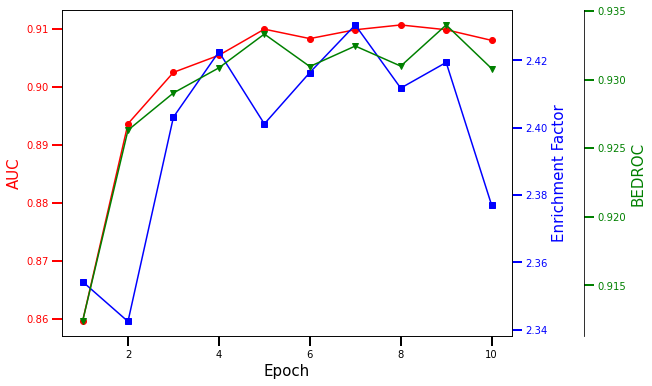

In [68]:
plot_indicators(auc_avg, ef_avg, bedroc_avg)

From the plot above, we can see that after 10 epochs of training, the independent model reaches a relatively high AUC, BEDROC and EF score. Is is also very likely that the model has already converged. We will use these three metrics (AUC, BEDROC, EF) to evaluate other models as well, and a comparison between different models will be presented at the end.

### 2.3 Multi-task Model

Next, we will create a multi-task model that learns from all targets at the same time.

#### (a) Base multi-task model

To begin with, we will make all 3 shared layers not trainable and set Glorot normal starting points for model training. We are initially performing 20 epochs to train the base model.

In [69]:
# initialize 
initializer = keras.initializers.GlorotNormal(seed = 42)

w1 = [initializer(shape=(INPUT_FEATURE_SIZE, W1_UNIT)), np.zeros(W1_UNIT,)]
w2 = [initializer(shape=(W1_UNIT, W2_UNIT)), np.zeros(W2_UNIT,)]
w3 = [initializer(shape=(W2_UNIT, W3_UNIT)), np.zeros(W3_UNIT,)]
w_output = [initializer(shape=(W3_UNIT, OUTPUT_UNIT)), np.zeros(OUTPUT_UNIT,)]

# construct architecture
inputs = Input(shape=(INPUT_FEATURE_SIZE,))
shared_w1 = Dense(W1_UNIT, activation='relu', name='shared_w1', trainable=False)(inputs)
shared_w2 = Dense(W2_UNIT, activation='relu', name='shared_w2', trainable=False)(shared_w1)
shared_w3 = Dense(W3_UNIT, activation='relu', name='shared_w3', trainable=False)(shared_w2)

In [70]:
# make a dictionary of models for each task
models_mtl = dict()

for x in target_set:
    # use same architecture as the independent model, but
    # repeat the output layer
    output_layer = Dense(OUTPUT_UNIT, activation='linear')(shared_w3)
    model = Model(inputs=inputs, outputs = output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error')
    models_mtl[x] = model
    # get layers
    shared1 = models_mtl[x].get_layer('shared_w1')
    shared2 = models_mtl[x].get_layer('shared_w2')
    shared3 = models_mtl[x].get_layer('shared_w3')
    personal = models_mtl[x].layers[-1]
    # 
    shared1.set_weights(w1) 
    shared2.set_weights(w2)
    shared3.set_weights(w3)
    personal.set_weights(w_output)
    shared1.trainable = False
    shared2.trainable = False
    shared3.trainable = False
    personal.trainable = True

In [71]:
%%time
EPOCHS = 20
all_keys = target_set

# indicators
auc2, ef2, bedroc2 = [], [], []

for i in range(EPOCHS):
    # shuffle in place operation
    shuffle(all_keys)

    for x in all_keys:
        y_mtl, yhat_mtl = [], []
        
        # train the personalized layers ONLY
        cur = models_mtl[x].fit(np.array(X_train[x]), np.array(y_train[x]).reshape(-1, 1), 
            verbose = 0, epochs = 1, shuffle = True)
        yhat_mlp = models_mtl[x].predict(np.array(X_test[x]))
        
        y_mtl.append(np.array(y_test[x]).reshape(-1, 1).ravel())
        yhat_mtl.append(yhat_mlp.ravel())
    
        # post processing
        y_mtl = np.concatenate(y_mtl).reshape(-1, 1)
        yhat_mtl = np.concatenate(yhat_mtl).reshape(-1, 1)
        scores = np.concatenate((yhat_mtl, y_mtl), axis = 1)
        scores = sorted(scores, key = lambda x : x[0], reverse = True)
        
        # calculate EF, BEDROC and AUC for each target
        ef2.append(CalcEnrichment(scores, col = 1, fractions = [0.01]))
        bedroc2.append(CalcBEDROC(scores, col = 1, alpha = 20))
        if len(set(y_mtl.ravel())) == 1:
            auc_temp = 0
        else:
            auc_temp = roc_auc_score(y_mtl.ravel(), yhat_mtl.ravel())
        auc2.append(auc_temp)

ef2 = np.array(ef2).reshape(EPOCHS, 100)
bedroc2 = np.array(bedroc2).reshape(EPOCHS, 100)
auc2 = np.array(auc2).reshape(EPOCHS, 100)

Wall time: 6min 3s


In [72]:
last_ef2, last_bedroc2, last_auc2, ef_avg2, bedroc_avg2, auc_avg2 = post_process(ef2, bedroc2, auc2, EPOCHS,
                                                                    "Multi-task Base Model:\n")

Multi-task Base Model:

Epoch 1 	Average AUC: 0.568;  Average EF: 0.964;  Average BEDROC: 0.639.
Epoch 2 	Average AUC: 0.607;  Average EF: 1.070;  Average BEDROC: 0.679.
Epoch 3 	Average AUC: 0.639;  Average EF: 1.156;  Average BEDROC: 0.714.
Epoch 4 	Average AUC: 0.667;  Average EF: 1.315;  Average BEDROC: 0.745.
Epoch 5 	Average AUC: 0.690;  Average EF: 1.420;  Average BEDROC: 0.767.
Epoch 6 	Average AUC: 0.710;  Average EF: 1.565;  Average BEDROC: 0.783.
Epoch 7 	Average AUC: 0.725;  Average EF: 1.619;  Average BEDROC: 0.797.
Epoch 8 	Average AUC: 0.739;  Average EF: 1.664;  Average BEDROC: 0.807.
Epoch 9 	Average AUC: 0.750;  Average EF: 1.707;  Average BEDROC: 0.817.
Epoch 10 	Average AUC: 0.759;  Average EF: 1.782;  Average BEDROC: 0.825.
Epoch 11 	Average AUC: 0.767;  Average EF: 1.786;  Average BEDROC: 0.831.
Epoch 12 	Average AUC: 0.773;  Average EF: 1.837;  Average BEDROC: 0.838.
Epoch 13 	Average AUC: 0.779;  Average EF: 1.880;  Average BEDROC: 0.843.
Epoch 14 	Average AUC: 

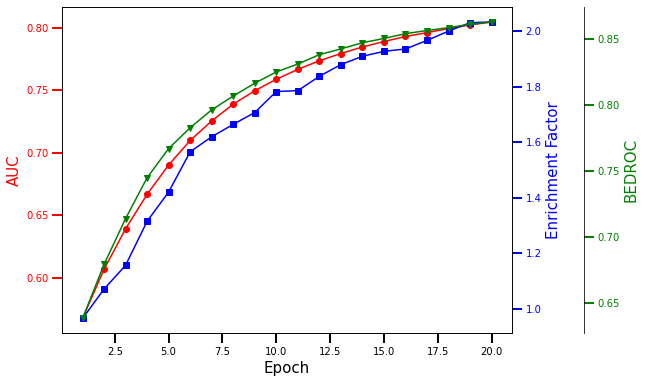

In [73]:
plot_indicators(auc_avg2, ef_avg2, bedroc_avg2)

From the plot above, we can see that multi-task model has a more smooth and gradual training process. However, after 20 epochs, the model has not converged. Next, we will fine tune the model by making one shared layer trainable each time.

#### (b) Fine tuning the multi-task model

Now let's see if we can make the model better through fine tuning the base multi-task model. We will make one shared layer traniable each time until all 3 shared layers are all trainable.


#### Make the third shared layer trainable

In [74]:
# fine tune
models_mtl[x].get_layer('shared_w1').trainable = False
models_mtl[x].get_layer('shared_w2').trainable = False
models_mtl[x].get_layer('shared_w3').trainable = True

In [75]:
%%time
EPOCHS = 20

# indicators
auc3, ef3, bedroc3 = [], [], []

for i in range(EPOCHS):
    # shuffle in place operation
    shuffle(all_keys)

    for x in all_keys:
        y_mtl, yhat_mtl = [], []
        
        cur = models_mtl[x].fit(np.array(X_train[x]), np.array(y_train[x]).reshape(-1, 1), 
            verbose = 0, epochs = 1, shuffle = True)
        yhat_mlp = models_mtl[x].predict(np.array(X_test[x]))
        
        y_mtl.append(np.array(y_test[x]).reshape(-1, 1).ravel())
        yhat_mtl.append(yhat_mlp.ravel())
    
        # post processing
        y_mtl = np.concatenate(y_mtl).reshape(-1, 1)
        yhat_mtl = np.concatenate(yhat_mtl).reshape(-1, 1)
        scores = np.concatenate((yhat_mtl, y_mtl), axis = 1)
        scores = sorted(scores, key = lambda x : x[0], reverse = True)
        
        # calculate EF, BEDROC and AUC for each target
        ef3.append(CalcEnrichment(scores, col = 1, fractions = [0.01]))
        bedroc3.append(CalcBEDROC(scores, col = 1, alpha = 20))
        if len(set(y_mtl.ravel())) == 1:
            auc_temp = 0
        else:
            auc_temp = roc_auc_score(y_mtl.ravel(), yhat_mtl.ravel())
        auc3.append(auc_temp)

ef3 = np.array(ef3).reshape(EPOCHS, 100)
bedroc3 = np.array(bedroc3).reshape(EPOCHS, 100)
auc3 = np.array(auc3).reshape(EPOCHS, 100)

Wall time: 5min 41s


In [76]:
last_ef3, last_bedroc3, last_auc3, ef_avg3, bedroc_avg3, auc_avg3 = post_process(ef3, bedroc3, auc3, EPOCHS,
                                                                    "Multi-task Model (fine tuning):\n")

Multi-task Model (fine tuning):

Epoch 1 	Average AUC: 0.807;  Average EF: 2.046;  Average BEDROC: 0.864.
Epoch 2 	Average AUC: 0.809;  Average EF: 2.039;  Average BEDROC: 0.866.
Epoch 3 	Average AUC: 0.811;  Average EF: 2.056;  Average BEDROC: 0.866.
Epoch 4 	Average AUC: 0.812;  Average EF: 2.055;  Average BEDROC: 0.868.
Epoch 5 	Average AUC: 0.814;  Average EF: 2.057;  Average BEDROC: 0.869.
Epoch 6 	Average AUC: 0.815;  Average EF: 2.091;  Average BEDROC: 0.871.
Epoch 7 	Average AUC: 0.816;  Average EF: 2.062;  Average BEDROC: 0.871.
Epoch 8 	Average AUC: 0.817;  Average EF: 2.064;  Average BEDROC: 0.872.
Epoch 9 	Average AUC: 0.818;  Average EF: 2.084;  Average BEDROC: 0.873.
Epoch 10 	Average AUC: 0.819;  Average EF: 2.111;  Average BEDROC: 0.873.
Epoch 11 	Average AUC: 0.820;  Average EF: 2.085;  Average BEDROC: 0.874.
Epoch 12 	Average AUC: 0.821;  Average EF: 2.068;  Average BEDROC: 0.874.
Epoch 13 	Average AUC: 0.822;  Average EF: 2.052;  Average BEDROC: 0.874.
Epoch 14 	Aver

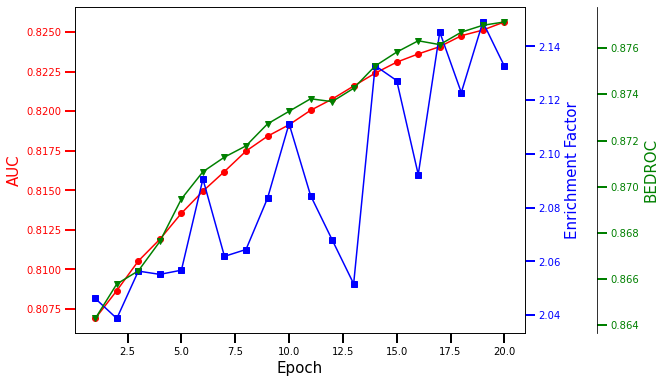

In [77]:
plot_indicators(auc_avg3, ef_avg3, bedroc_avg3)

From the plot above, we can find that the AUC, BEDROC and EF values continue to increase. The model has not converged. We will let the second shared layers also trainable and continue to train the model.

#### Make the second and third shared layers trainable

In [78]:
# fine tune
models_mtl[x].get_layer('shared_w1').trainable = False
models_mtl[x].get_layer('shared_w2').trainable = True
models_mtl[x].get_layer('shared_w3').trainable = True

In [79]:
%%time
EPOCHS = 20

# indicators
auc4, ef4, bedroc4 = [], [], []

for i in range(EPOCHS):
    # shuffle in place operation
    shuffle(all_keys)

    for x in all_keys:
        y_mtl, yhat_mtl = [], []
        
        cur = models_mtl[x].fit(np.array(X_train[x]), np.array(y_train[x]).reshape(-1, 1), 
            verbose = 0, epochs = 1, shuffle = True, batch_size=64, steps_per_epoch=8)
        yhat_mlp = models_mtl[x].predict(np.array(X_test[x]))
        
        y_mtl.append(np.array(y_test[x]).reshape(-1, 1).ravel())
        yhat_mtl.append(yhat_mlp.ravel())
    
        # post processing
        y_mtl = np.concatenate(y_mtl).reshape(-1, 1)
        yhat_mtl = np.concatenate(yhat_mtl).reshape(-1, 1)
        scores = np.concatenate((yhat_mtl, y_mtl), axis = 1)
        scores = sorted(scores, key = lambda x : x[0], reverse = True)
        
        # calculate EF, BEDROC and AUC for each target
        ef4.append(CalcEnrichment(scores, col = 1, fractions = [0.01]))
        bedroc4.append(CalcBEDROC(scores, col = 1, alpha = 20))
        if len(set(y_mtl.ravel())) == 1:
            auc_temp = 0
        else:
            auc_temp = roc_auc_score(y_mtl.ravel(), yhat_mtl.ravel())
        auc4.append(auc_temp)

ef4 = np.array(ef4).reshape(EPOCHS, 100)
bedroc4 = np.array(bedroc4).reshape(EPOCHS, 100)
auc4 = np.array(auc4).reshape(EPOCHS, 100)

Wall time: 4min 57s


In [80]:
last_ef4, last_bedroc4, last_auc4, ef_avg4, bedroc_avg4, auc_avg4 = post_process(ef4, bedroc4, auc4, EPOCHS,
                                                                    "Multi-task Model (fine tuning):\n")

Multi-task Model (fine tuning):

Epoch 1 	Average AUC: 0.826;  Average EF: 2.149;  Average BEDROC: 0.877.
Epoch 2 	Average AUC: 0.826;  Average EF: 2.133;  Average BEDROC: 0.877.
Epoch 3 	Average AUC: 0.826;  Average EF: 2.118;  Average BEDROC: 0.878.
Epoch 4 	Average AUC: 0.826;  Average EF: 2.128;  Average BEDROC: 0.878.
Epoch 5 	Average AUC: 0.826;  Average EF: 2.128;  Average BEDROC: 0.878.
Epoch 6 	Average AUC: 0.826;  Average EF: 2.110;  Average BEDROC: 0.877.
Epoch 7 	Average AUC: 0.827;  Average EF: 2.085;  Average BEDROC: 0.878.
Epoch 8 	Average AUC: 0.827;  Average EF: 2.117;  Average BEDROC: 0.878.
Epoch 9 	Average AUC: 0.827;  Average EF: 2.132;  Average BEDROC: 0.878.
Epoch 10 	Average AUC: 0.827;  Average EF: 2.134;  Average BEDROC: 0.878.
Epoch 11 	Average AUC: 0.827;  Average EF: 2.114;  Average BEDROC: 0.878.
Epoch 12 	Average AUC: 0.827;  Average EF: 2.102;  Average BEDROC: 0.878.
Epoch 13 	Average AUC: 0.827;  Average EF: 2.116;  Average BEDROC: 0.878.
Epoch 14 	Aver

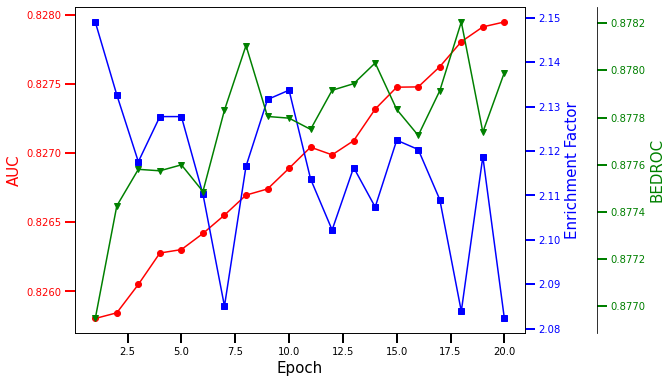

In [81]:
plot_indicators(auc_avg4, ef_avg4, bedroc_avg4)

From the plot above, after another 20 epochs of training, the BEDROC and EF values are not increasing anymore and begin to fluctuate. The AUC score is still increasing. We will continue to train the model with all 3 shared layers tranable, but the steps per epoch are limited to be as small as 4.

#### Make the first, second and third shared layers trainable

In [82]:
# fine tune
models_mtl[x].get_layer('shared_w1').trainable = True
models_mtl[x].get_layer('shared_w2').trainable = True
models_mtl[x].get_layer('shared_w3').trainable = True

In [83]:
%%time
EPOCHS = 20

# indicators
auc5, ef5, bedroc5 = [], [], []

for i in range(EPOCHS):
    # shuffle in place operation
    shuffle(all_keys)

    for x in all_keys:
        y_mtl, yhat_mtl = [], []
        
        cur = models_mtl[x].fit(np.array(X_train[x]), np.array(y_train[x]).reshape(-1, 1), 
            verbose = 0, epochs = 1, shuffle = True, batch_size=64, steps_per_epoch=4)
        yhat_mlp = models_mtl[x].predict(np.array(X_test[x]))
        
        y_mtl.append(np.array(y_test[x]).reshape(-1, 1).ravel())
        yhat_mtl.append(yhat_mlp.ravel())
    
        # post processing
        y_mtl = np.concatenate(y_mtl).reshape(-1, 1)
        yhat_mtl = np.concatenate(yhat_mtl).reshape(-1, 1)
        scores = np.concatenate((yhat_mtl, y_mtl), axis = 1)
        scores = sorted(scores, key = lambda x : x[0], reverse = True)
        
        # calculate EF, BEDROC and AUC for each target
        ef5.append(CalcEnrichment(scores, col = 1, fractions = [0.01]))
        bedroc5.append(CalcBEDROC(scores, col = 1, alpha = 20))
        if len(set(y_mtl.ravel())) == 1:
            auc_temp = 0
        else:
            auc_temp = roc_auc_score(y_mtl.ravel(), yhat_mtl.ravel())
        auc5.append(auc_temp)

ef5 = np.array(ef5).reshape(EPOCHS, 100)
bedroc5 = np.array(bedroc5).reshape(EPOCHS, 100)
auc5 = np.array(auc5).reshape(EPOCHS, 100)

Wall time: 4min 8s


In [84]:
last_ef5, last_bedroc5, last_auc5, ef_avg5, bedroc_avg5, auc_avg5 = post_process(ef5, bedroc5, auc5, EPOCHS,
                                                                    "Multi-task Model (fine tuning):\n")

Multi-task Model (fine tuning):

Epoch 1 	Average AUC: 0.828;  Average EF: 2.102;  Average BEDROC: 0.878.
Epoch 2 	Average AUC: 0.828;  Average EF: 2.086;  Average BEDROC: 0.878.
Epoch 3 	Average AUC: 0.828;  Average EF: 2.097;  Average BEDROC: 0.878.
Epoch 4 	Average AUC: 0.828;  Average EF: 2.119;  Average BEDROC: 0.878.
Epoch 5 	Average AUC: 0.828;  Average EF: 2.102;  Average BEDROC: 0.878.
Epoch 6 	Average AUC: 0.828;  Average EF: 2.122;  Average BEDROC: 0.878.
Epoch 7 	Average AUC: 0.828;  Average EF: 2.090;  Average BEDROC: 0.878.
Epoch 8 	Average AUC: 0.828;  Average EF: 2.103;  Average BEDROC: 0.878.
Epoch 9 	Average AUC: 0.828;  Average EF: 2.119;  Average BEDROC: 0.879.
Epoch 10 	Average AUC: 0.828;  Average EF: 2.119;  Average BEDROC: 0.879.
Epoch 11 	Average AUC: 0.828;  Average EF: 2.153;  Average BEDROC: 0.879.
Epoch 12 	Average AUC: 0.828;  Average EF: 2.169;  Average BEDROC: 0.879.
Epoch 13 	Average AUC: 0.828;  Average EF: 2.152;  Average BEDROC: 0.879.
Epoch 14 	Aver

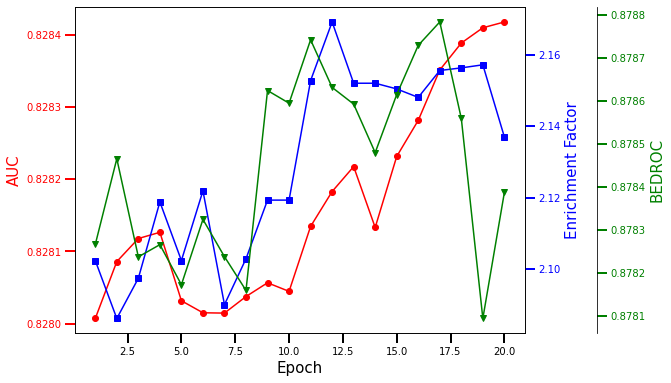

In [85]:
plot_indicators(auc_avg5, ef_avg5, bedroc_avg5)

From the plot above, the BEDROC and EF values continue to fluctuate. Although the AUC score is still increasing, but the increment is very limited. We will stop training here.

### 2.4 Perform Multi-task Classification by Adding a Self-supervised Auxiliary Task

#### Self-supervised Auxiliary Task -- Predict Molecular weights

In this section, we will first train a multi-task model to predict different molecular weights, which is our self-supervised auxiliary task.

Base on that, another multi-task model will be build with the first few layers transferred from the self-supervised model. Then, fix the weights of those layers and train the other layers to predict binding between ligands and targets.

In [86]:
molecular_weights = []

for line in smiles:
    molecular_weights.append(Descriptors.MolWt(MolFromSmiles(line)))

y_train_weight, y_test_weight = collections.defaultdict(list), collections.defaultdict(list)

# add molecular weight to training and testing data
for index, val in enumerate(index_train):
    y_train_weight[target_train[index]].append(molecular_weights[val])

for index, val in enumerate(index_test):
    y_test_weight[target_test[index]].append(molecular_weights[val])

In [133]:
inputs2 = Input(shape=(INPUT_FEATURE_SIZE,))
weight_w1 = Dense(W1_UNIT, activation='relu', name='weight_w1', trainable=False)(inputs2)
weight_w2 = Dense(W2_UNIT, activation='relu', name='weight_w2', trainable=False)(weight_w1)
weight_w3 = Dense(W3_UNIT, activation='relu', name='weight_w3', trainable=False)(weight_w2)

# make a dictionary of models for each task
models_weight = dict()

for x in target_set:
    # use same architecture as the independent model, but
    # repeat the output layer
    output_layer2 = Dense(OUTPUT_UNIT, activation='linear')(weight_w3)
    model = Model(inputs=inputs2, outputs = output_layer2)
    model.compile(optimizer='adam', loss='mean_squared_error')
    models_weight[x] = model
    # get layers
    weight1 = models_weight[x].get_layer('weight_w1')
    weight2 = models_weight[x].get_layer('weight_w2')
    weight3 = models_weight[x].get_layer('weight_w3')

In [145]:
%%time
EPOCHS = 30

train_mse, test_mse = [], []

for i in range(EPOCHS):
    shuffle(all_keys) # shuffle in place operation
    
    for x in all_keys:
        cur = models_weight[x].fit(np.array(X_train[x]), np.array(y_train_weight[x]).reshape(-1, 1),
                                verbose = 0, batch_size = 4, epochs = 1, shuffle = True,
                                validation_data = (np.array(X_test[x]), np.array(y_test_weight[x]).reshape(-1, 1)))
        
        train_mse.append(cur.history['loss'])
        test_mse.append(cur.history['val_loss'])
        
train_mse = np.array(train_mse).reshape(EPOCHS, 100)
test_mse = np.array(test_mse).reshape(EPOCHS, 100)

Wall time: 27min 18s


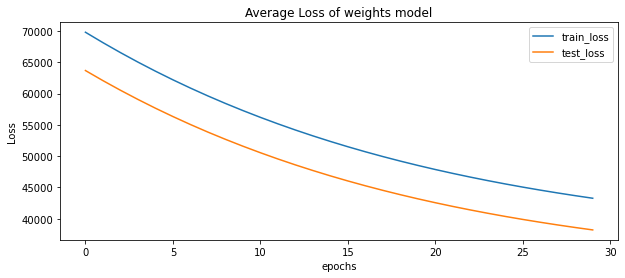

In [146]:
train_mse_avg = np.mean(train_mse, axis = 1)
test_mse_avg = np.mean(test_mse, axis = 1)

plt.figure(figsize=(10,4))
plt.plot(train_mse_avg)
plt.plot(test_mse_avg)
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(('train_loss', 'test_loss'))
plt.title('Average Loss of weights model')
plt.show()

**Transfer information from the self-supervised model to multi-task model**

Next, we will keep the 3 shared layer unchanged, directly copy the weights from the self-supervised model and train the new layers.

In [147]:
#get weights of self-supervised multi-task model
w1 = model.get_layer('weight_w1').get_weights()
w2 = model.get_layer('weight_w2').get_weights()
w3 = model.get_layer('weight_w3').get_weights()
w_output = [initializer(shape=(W3_UNIT, OUTPUT_UNIT)), np.zeros(OUTPUT_UNIT,)]

for x in target_set:
    output_layer = Dense(OUTPUT_UNIT, activation='linear')(shared_w3)
    model = Model(inputs=inputs, outputs = output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error')
    models_mtl[x] = model
    # get layers
    shared1 = models_mtl[x].get_layer('shared_w1')
    shared2 = models_mtl[x].get_layer('shared_w2')
    shared3 = models_mtl[x].get_layer('shared_w3')
    personal = models_mtl[x].layers[-1]
    # 
    shared1.set_weights(w1) 
    shared2.set_weights(w2)
    shared3.set_weights(w3)
    personal.set_weights(w_output)
    shared1.trainable = False
    shared2.trainable = False
    shared3.trainable = False
    personal.trainable = True

ValueError: No such layer: weight_w1.

In [ ]:
%%time
EPOCHS = 20

# indicators
auc6, ef6, bedroc6 = [], [], []

for i in range(EPOCHS):
    shuffle(all_keys) # shuffle in place operation
    
    for x in all_keys:
        y_mtl, yhat_mtl = [], []
        
        # then train on binding data
        cur = models_mtl[x].fit(np.array(X_train[x]), np.array(y_train[x]).reshape(-1, 1), 
                                verbose = 0, batch_size = 4, epochs = 1, shuffle = True)
        
        yhat_mlp = models_mtl[x].predict(np.array(X_test[x]))
        y_mtl.append(np.array(y_test[x]).ravel())
        yhat_mtl.append(yhat_mlp.ravel())
    
        # post processing
        y_mtl = np.concatenate(y_mtl).reshape(-1, 1)
        yhat_mtl = np.concatenate(yhat_mtl).reshape(-1, 1)
        scores = np.concatenate((yhat_mtl, y_mtl), axis = 1)
        scores = sorted(scores, key = lambda x : x[0], reverse = True)
        
        # calculate EF and BEDROC for each target
        ef6.append(CalcEnrichment(scores, col = 1, fractions = [0.01]))
        bedroc6.append(CalcBEDROC(scores, col = 1, alpha = 20))
        if len(set(y_mtl.ravel())) == 1:
            auc_temp = 0
        else:
            auc_temp = roc_auc_score(y_mtl.ravel(), yhat_mtl.ravel())
        auc6.append(auc_temp)

ef6 = np.array(ef6).reshape(EPOCHS, 100)
bedroc6 = np.array(bedroc6).reshape(EPOCHS, 100)
auc6 = np.array(auc6).reshape(EPOCHS, 100)

In [ ]:
last_ef6, last_bedroc6, last_auc6, ef_avg6, bedroc_avg6, auc_avg6 = post_process(ef6, bedroc6, auc6, EPOCHS, 
                                                                     "Multi-task Model with self-supervised auxiliary task:\n")

In [ ]:
plot_indicators(auc_avg6, ef_avg6, bedroc_avg6)

From the plot above, the model has not converged. We will fine tune the model by make the third shared layer trainable.

#### Fine tuning the multi-task model

Now let's see if we can make the model better through fine tuning the base multi-task model. We will make the third shared layer traniable.


In [ ]:
# fine tune
models_mtl[x].get_layer('shared_w1').trainable = False
models_mtl[x].get_layer('shared_w2').trainable = False
models_mtl[x].get_layer('shared_w3').trainable = True

In [ ]:
%%time
EPOCHS = 40

# indicators
auc7, ef7, bedroc7 = [], [], []

for i in range(EPOCHS):
    # shuffle in place operation
    shuffle(all_keys)

    for x in all_keys:
        y_mtl, yhat_mtl = [], []
        
        cur = models_mtl[x].fit(np.array(X_train[x]), np.array(y_train[x]).reshape(-1, 1), 
            verbose = 0, epochs = 1, shuffle = True)
        yhat_mlp = models_mtl[x].predict(np.array(X_test[x]))
        
        y_mtl.append(np.array(y_test[x]).reshape(-1, 1).ravel())
        yhat_mtl.append(yhat_mlp.ravel())
    
        # post processing
        y_mtl = np.concatenate(y_mtl).reshape(-1, 1)
        yhat_mtl = np.concatenate(yhat_mtl).reshape(-1, 1)
        scores = np.concatenate((yhat_mtl, y_mtl), axis = 1)
        scores = sorted(scores, key = lambda x : x[0], reverse = True)
        
        # calculate EF, BEDROC and AUC for each target
        ef7.append(CalcEnrichment(scores, col = 1, fractions = [0.01]))
        bedroc7.append(CalcBEDROC(scores, col = 1, alpha = 20))
        if len(set(y_mtl.ravel())) == 1:
            auc_temp = 0
        else:
            auc_temp = roc_auc_score(y_mtl.ravel(), yhat_mtl.ravel())
        auc7.append(auc_temp)

ef7 = np.array(ef7).reshape(EPOCHS, 100)
bedroc7 = np.array(bedroc7).reshape(EPOCHS, 100)
auc7 = np.array(auc7).reshape(EPOCHS, 100)

In [ ]:
last_ef7, last_bedroc7, last_auc7, ef_avg7, bedroc_avg7, auc_avg7 = post_process(ef7, bedroc7, auc7, EPOCHS, 
                                                    "Multi-task Model with self-supervised auxiliary task (fine tune):\n")

In [ ]:
plot_indicators(auc_avg7, ef_avg7, bedroc_avg7)

From the previous plot, we can find the performance of the model is improved a little bit. It seems the model has converged. We will stop training here.

### 2.5 Comparison of Model Performance

In this section, we will compare the performance of independent target model, multi-task model and multi-task model with self-supervised auxiliary task, in terms of AUC, BEDROC and EF scores. 

The boxplot of each score for all targets is shown as follows.

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24,8))

plt.subplot(1,3,1)
plt.boxplot(np.concatenate([last_auc,last_auc5,last_auc7]).reshape((3,100)).T)
plt.xticks(range(1,4),['Independent', 'Multi-task', 'Self-supervised task'],rotation=45,fontsize=20)
plt.xlabel('',fontsize=20)
plt.ylabel('Score',fontsize=20)
plt.title("AUC",fontsize=20)

plt.subplot(1,3,2)
plt.boxplot(np.concatenate([last_ef,last_ef5,last_ef7]).reshape((3,100)).T)
plt.xticks(range(1,4),['Independent', 'Multi-task', 'Self-supervised task'],rotation=45,fontsize=20)
plt.xlabel('',fontsize=20)
plt.ylabel('Score',fontsize=20)
plt.title("Enrichment Factor",fontsize=20)

plt.subplot(1,3,3)
plt.boxplot(np.concatenate([last_bedroc,last_bedroc5,last_bedroc7]).reshape((3,100)).T)
plt.xticks(range(1,4),['Independent', 'Multi-task', 'Self-supervised task'],rotation=45,fontsize=20)
plt.xlabel('',fontsize=20)
plt.ylabel('Score',fontsize=20)
plt.title("BEDROC",fontsize=20);

From the boxplots, we can find that 

- Based on AUC score, the independent target model has the best performance. It has the largest average/median AUC score and the variation is relatively small compared to the other two models (narrower box). 

- Based on EF, three models have similar performance. The distribution of EF scores for all 3 models have heavy tails, and thus we can see a lot of outliers. 

- Based on BEDROC, the independent target model has the best performance. Although three models have similar median values of BEDROC, independent target model has the smallest variation (narrowest box).

As a result, for this dataset, the independent target model has the best performance in terms of predicting the binding between ligands and targets.

##### REFERENCES:

1. https://www.ebi.ac.uk/chembl/
2. https://www.ebi.ac.uk/about
3. https://pubs.acs.org/doi/10.1021/acscentsci.7b00572
4. https://chembl.gitbook.io/chembl-interface-documentation/about
5. https://s2.smu.edu/~eclarson/pubs/2018implicit.pdf
6. https://new.pharmacelera.com/science/measuring-virtual-screening-accuracy/
